In [1]:
# !pip install git+https://github.com/outbreak-info/python-outbreak-info@wastewater_sprint

In [1]:
import scipy
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
import matplotlib.dates as mdates

matplotlib.rcParams['hatch.linewidth'] = 0.5
matplotlib.rcParams['font.family'] ='sans-serif'
locator = mdates.MonthLocator(bymonthday=1)


/tmp/ipykernel_154608/3826763493.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
from outbreak_data import authenticate_user

In [3]:
authenticate_user.authenticate_new_user()

Please open this url in a web browswer and authenticate with your GISAID credentials:  https://gpsapi.epicov.org/epi3/gps_authenticate/NLTEUIWZGTKWCHCCNGNDXWDBLLRTMWFVCVWMOMHVHRGGHSUTFPIWXSOOLFGOMVCSTQQHHTUMBYLMENEMHRNPZEWXZQDTUJBHBOPTJMKIJOCLJRXYDOVYZZYKQOFNBPIM
Waiting for authorization response... [Press Ctrl-C to abort]
Authenticated successfully!

    TERMS OF USE for Python Package and
    Reminder of GISAID's Database Access Agreement
    Your ability to access and use Data in GISAID, including your access and
    use of same via R Package, is subject to the terms and conditions of
    GISAID's Database Access Agreement (“DAA”) (which you agreed to
    when you requested access credentials to GISAID), as well as the
    following terms:
    1. You will treat all data contained in the R Package consistent with
    other Data in GISAID and in accordance with GISAID's Database Access
    Agreement;
    2. You will not distribute, or re-distribute Data made available through
    GIS

In [4]:
from outbreak_data import outbreak_data
from outbreak_tools import outbreak_tools
from outbreak_tools import outbreak_clustering

In [5]:
def plot_out(fname):
    plt.savefig(fname, format='pdf', bbox_inches='tight')
    plt.show();

In [286]:
def binom_kernel(n, squeeze=0):
    return np.array([scipy.special.binom(n+2*squeeze, x) for x in np.arange(n)+squeeze])
    
smooth = binom_kernel(7*5, 35) # 21
# plt.plot(smooth)

#### pull ww data

In [252]:
state = "California"
state_id = 'USA_US-CA'
startdate, enddate = "2023-09-02", "2024-01-02"
ww_samples = outbreak_data.get_wastewater_samples(region=state, date_range=[startdate, enddate], server='dev.outbreak.info')
ww_lineages = outbreak_data.get_wastewater_lineages(ww_samples, server='dev.outbreak.info')
ww_mutations = outbreak_data.get_wastewater_mutations(ww_samples, server='dev.outbreak.info')

In [253]:
ww_prevalences = outbreak_tools.datebin_and_agg(ww_lineages, weights=outbreak_tools.get_ww_weights(ww_lineages), startdate=startdate, enddate=enddate, freq='7D', rolling=[1,4,1], log=False)
ww_prevalences_daily_unsmoothed = outbreak_tools.datebin_and_agg(ww_lineages, weights=outbreak_tools.get_ww_weights(ww_lineages), startdate=startdate, enddate=enddate, freq='D', rolling=1, log=False)
ww_prevalences_daily, ww_prevalences_daily_varis = outbreak_tools.datebin_and_agg(ww_lineages, weights=outbreak_tools.get_ww_weights(ww_lineages), startdate=startdate, enddate=enddate, freq='D', rolling=smooth, log=False, variance=True)

In [254]:
clinical_samples = outbreak_data.all_lineage_prevalences(location=state_id, other_threshold=0.0, nday_threshold=1)

In [255]:
clinical_prevalences = outbreak_tools.datebin_and_agg(clinical_samples, weights=clinical_samples['total_count'], startdate=startdate, enddate=enddate, freq='7D', rolling=[1,4,1])
clinical_prevalences_daily_unsmoothed = outbreak_tools.datebin_and_agg(clinical_samples, weights=clinical_samples['total_count'], startdate=startdate, enddate=enddate, rolling=1, freq='D', log=False)
clinical_prevalences_daily, clinical_prevalences_daily_varis = outbreak_tools.datebin_and_agg(clinical_samples, weights=clinical_samples['total_count'], startdate=startdate, enddate=enddate, rolling=smooth, freq='D', log=False, variance=True)

#### get the lineage tree

In [256]:
tree = outbreak_clustering.get_compressed_tree()
lineage_key = outbreak_clustering.get_lineage_key(tree)

In [257]:
samples_per_site = ww_samples['sra_accession'].groupby(ww_samples['collection_site_id']).nunique()

date_range_per_site = ww_samples.index.to_series().apply(pd.to_datetime).groupby(ww_samples['collection_site_id']) #.apply(pd.to_datetime)
date_range_per_site = date_range_per_site.apply(lambda x: x.max() - x.min())

sites_for_vl = (date_range_per_site.apply(lambda x: x.days >= 14)) & (samples_per_site >= 3)
samples_for_vl = ww_samples[ww_samples['collection_site_id'].isin(list(sites_for_vl.index[sites_for_vl]))]

#### cluster lineages on combined prevalences

In [259]:
viral_load = samples_for_vl.set_index(pd.Series(['viral_load'] * len(samples_for_vl)), append=True)
c = 'normed_viral_load'
viral_load_unsmoothed = outbreak_tools.datebin_and_agg(viral_load, weights=viral_load['ww_population'].fillna(1000), startdate=startdate, enddate=enddate, freq='D', column=c, norm=False, rolling=1, log=False)
viral_load_weekly, viral_load_weekly_varis = outbreak_tools.datebin_and_agg(viral_load, weights=viral_load['ww_population'].fillna(1000), startdate=startdate, enddate=enddate, freq='7D', column=c, norm=False, rolling=[1,4,1], log=False, variance=True)
viral_load, viral_load_varis = outbreak_tools.datebin_and_agg(viral_load, weights=viral_load['ww_population'].fillna(1000), startdate=startdate, enddate=enddate, freq='D', column=c, norm=False, rolling=smooth, log=False, variance=True)

viral_load_unsmoothed = viral_load_unsmoothed['viral_load']
viral_load_weekly = viral_load_weekly['viral_load']
viral_load_weekly_varis = viral_load_weekly_varis['viral_load']
viral_load = viral_load['viral_load']
viral_load_varis = viral_load_varis['viral_load']

In [260]:
ww_prev_data = ww_prevalences.mul(viral_load_weekly, axis=0)[-6:].sum()
clinical_prev_data = clinical_prevalences.mul(viral_load_weekly, axis=0)[-6:].sum()
combined_prevalences = (ww_prev_data/ww_prev_data.sum()).add(clinical_prev_data/clinical_prev_data.sum(), fill_value=0)

In [261]:
clusters = outbreak_clustering.cluster_lineages(combined_prevalences, tree, lineage_key=lineage_key, n=10, alpha=0.25)

#### prepare data for plotting

In [262]:
def rename_for_paper(df0):
    df0.columns = [c.replace(' **','').replace('*','.X').replace(')','.X)') for c in df0.columns]
    # df0.columns = [c.split('.X ')[-1].replace('other ','') for c in df0.columns]
    return df0

clustered_cl_prevalences, root_lineages, isnatural = outbreak_tools.cluster_df(clinical_prevalences.fillna(0), clusters, tree, lineage_key)
clustered_cl_prevalences_daily_unsmoothed, _, _ = outbreak_tools.cluster_df(clinical_prevalences_daily_unsmoothed.fillna(0), clusters, tree, lineage_key)
clustered_cl_prevalences_daily, _, _ = outbreak_tools.cluster_df(clinical_prevalences_daily.fillna(0), clusters, tree, lineage_key)
clustered_cl_prevalences_daily_varis, _, _ = outbreak_tools.cluster_df(clinical_prevalences_daily_varis.fillna(0), clusters, tree, lineage_key, norm=False)
clustered_ww_prevalences, _, _ = outbreak_tools.cluster_df(ww_prevalences.fillna(0), clusters, tree, lineage_key)
clustered_ww_prevalences_daily_unsmoothed, _, _ = outbreak_tools.cluster_df(ww_prevalences_daily_unsmoothed.fillna(0), clusters, tree, lineage_key)
clustered_ww_prevalences_daily, _, _ = outbreak_tools.cluster_df(ww_prevalences_daily.fillna(0), clusters, tree, lineage_key)
clustered_ww_prevalences_daily_varis, _, _ = outbreak_tools.cluster_df(ww_prevalences_daily_varis.fillna(0), clusters, tree, lineage_key, norm=False)

clustered_cl_prevalences = rename_for_paper(clustered_cl_prevalences)
clustered_cl_prevalences_daily_unsmoothed = rename_for_paper(clustered_cl_prevalences_daily_unsmoothed)
clustered_cl_prevalences_daily = rename_for_paper(clustered_cl_prevalences_daily)
clustered_cl_prevalences_daily_varis = rename_for_paper(clustered_cl_prevalences_daily_varis)
clustered_ww_prevalences = rename_for_paper(clustered_ww_prevalences)
clustered_ww_prevalences_daily_unsmoothed = rename_for_paper(clustered_ww_prevalences_daily_unsmoothed)
clustered_ww_prevalences_daily = rename_for_paper(clustered_ww_prevalences_daily)
clustered_ww_prevalences_daily_varis = rename_for_paper(clustered_ww_prevalences_daily_varis)

In [263]:
mut = '11042T'

# expansion to include records for all plausibly scanned mutations
ww_mutations2 = ww_mutations.xs(mut, level=1, drop_level=False)
ww_mutations2 = ww_mutations2.set_index(ww_mutations2['sra_accession'], append=True).unstack(1).stack(dropna=False)
ww_mutations3 = ww_mutations2.reset_index(level=1, drop=True)
ww_mutations4 = ww_mutations3.interpolate().bfill().ffill()
ww_mutations4['prevalence'] = ww_mutations3['prevalence']

/tmp/ipykernel_154608/2415003109.py:5: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  ww_mutations2 = ww_mutations2.set_index(ww_mutations2['sra_accession'], append=True).unstack(1).stack(dropna=False)
/tmp/ipykernel_154608/2415003109.py:7: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  ww_mutations4 = ww_mutations3.interpolate().bfill().ffill()


In [264]:
ww_muts = outbreak_tools.datebin_and_agg(ww_mutations4, weights=outbreak_tools.get_ww_weights(ww_mutations4), startdate=startdate, enddate=enddate, freq='7D', trustna=0.001, log=True, norm=False)
ww_muts_daily = outbreak_tools.datebin_and_agg(ww_mutations4, weights=outbreak_tools.get_ww_weights(ww_mutations4), startdate=startdate, enddate=enddate, freq='D', trustna=0.001, log=True, norm=False)
ww_muts_daily_s, ww_muts_daily_vars = outbreak_tools.datebin_and_agg(ww_mutations4, weights=outbreak_tools.get_ww_weights(ww_mutations4), startdate=startdate, enddate=enddate, freq='D', rolling=smooth, trustna=0.001, variance=True, log=True, norm=False)

In [265]:
cl_mut = outbreak_data.lineage_cl_prevalence(pango_lin='.', descendants=True, location=state_id, datemin=startdate, datemax=enddate, mutations='ORF1a:V3593F')

cl_prev_unsmoothed = outbreak_tools.datebin_and_agg(cl_mut.rename(columns={'proportion': 'prevalence'}), norm=False, freq='D', rolling=1)
cl_prev, cl_var = outbreak_tools.datebin_and_agg(cl_mut.rename(columns={'proportion': 'prevalence'}), norm=False, freq='D', rolling=smooth, variance=True)

#### wastewater plots

In [266]:
def lognorm_ci(x, r):
    return (np.exp(np.log(x)-(r**0.5/x)), np.exp(np.log(x)+(r**0.5/x)))

In [267]:
months = {'01': 'Jan', '02': 'Feb', '03': 'Mar', '04': 'Apr', '05': 'May', '06': 'Jun', '07': 'Jul', '08': 'Aug', '09': 'Sep', '10': 'Oct', '11': 'Nov', '12': 'Dec'}

def format_dateinterval_axis(ax, index, every_n=4, narrow=0, shift=0, tickRight=False):
    def format(x, pos):
        side = lambda y: [y.mid, y.left, y.right][(x==0) + 2*(x==len(index)-1)]
        month = side(index.get_level_values(0)[x]).date().strftime('%m')
        pmonth = side(index.get_level_values(0)[x-1]).date().strftime('%m')
        return months[month] if month != pmonth else ''
    ax.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(format))
    ax.set_xticks(np.arange(0, len(index), 1))
    ax.set_xlim(narrow+shift-0.5, len(index)-0.5-narrow+shift)
    ax.set_xlabel(None)
    if not tickRight:
        ax.spines[['right', 'top']].set_visible(False)
    else:
        ax.spines[['left', 'top']].set_visible(False)
        ax.yaxis.tick_right()

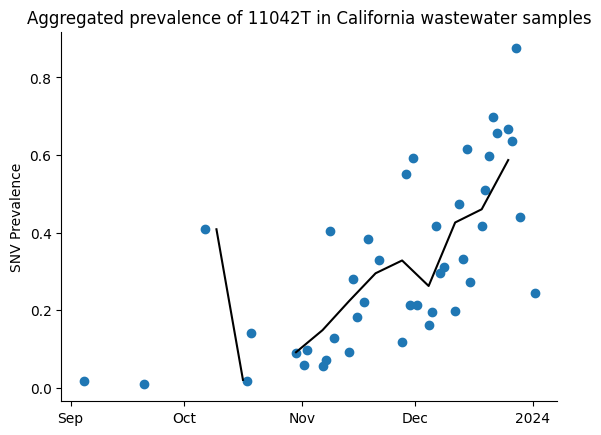

In [268]:
_,ax = plt.subplots()
ax.plot(ww_muts_daily.index.mid,ww_muts_daily[mut],'o',)
ax.plot(ww_muts.index.mid,ww_muts[mut],color='black')

ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(locator))
ax.spines[['right', 'top']].set_visible(False)

plt.title(f'Aggregated prevalence of {mut} in {state} wastewater samples')
plt.ylabel('SNV Prevalence')
plot_out('mut_prev_ww_week.pdf')

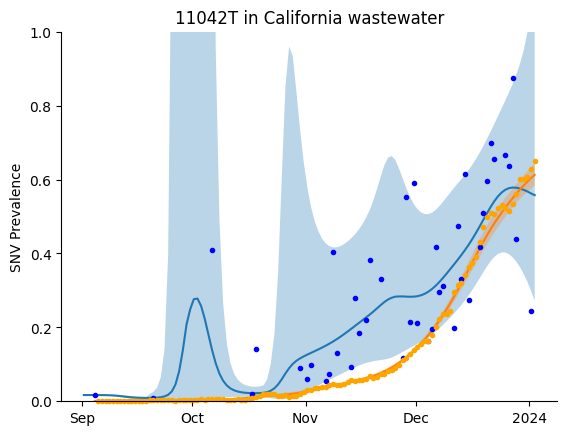

In [269]:
_,ax = plt.subplots()

l,u = lognorm_ci(ww_muts_daily_s, ww_muts_daily_vars)
ax.plot(ww_muts_daily_s[mut].index.mid, ww_muts_daily_s[mut])
ax.fill_between(ww_muts_daily_s[mut].index.mid, l[mut], u[mut], alpha=0.3, zorder=-1)


l,u = lognorm_ci(cl_prev, cl_var)
ax.plot(cl_prev.index.mid, cl_prev)
ax.fill_between(cl_var.index.mid, l.iloc[:,0], u.iloc[:,0], alpha=0.3, zorder=-1)

ax.plot(ww_muts_daily.index.mid,ww_muts_daily[mut],'.',color='blue',clip_on=False)
ax.plot(cl_prev_unsmoothed.index.mid,cl_prev_unsmoothed,'.',color='orange',clip_on=False)

ax.spines[['right', 'top']].set_visible(False)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(locator))

ax.set_ylim([0,1.0])
ax.set_title(f'{mut} in {state} wastewater')
ax.set_ylabel('SNV Prevalence')
plot_out('mut_prev_ww.pdf')

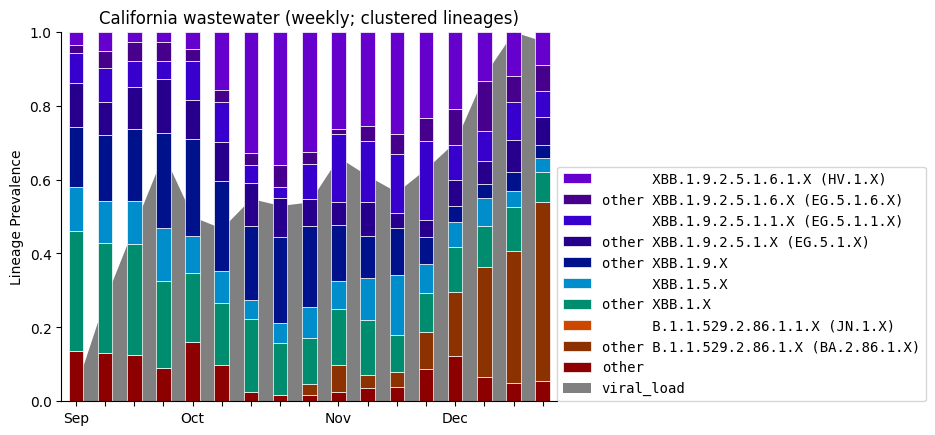

In [270]:
ax = (viral_load_weekly / viral_load_weekly.max()) \
    .interpolate().bfill().ffill().plot(kind='area', color='gray', linewidth=0)
colors = hsv_to_rgb(outbreak_tools.get_colors(root_lineages, isnatural, lineage_key))
clustered_ww_prevalences.plot(
    kind='bar', stacked=True, edgecolor='w', linewidth=.5, color=colors, ax=ax )
format_dateinterval_axis(ax, clustered_ww_prevalences.index)
plt.xticks(rotation=0)
plt.ylabel('Lineage Prevalence')
plt.legend(loc=(1,0), prop={"family":"monospace"}, reverse=True)
plt.title(f'{state} wastewater (weekly; clustered lineages)')
plt.ylim([0,1])
plot_out('lin_prev_bar_ww.pdf')

In [271]:
state_cases = pd.read_csv('https://data.chhs.ca.gov/datastore/dump/a3b94dd4-b866-4208-a811-980ed497d1d1?bom=True')

In [272]:
s = state_cases.set_index('date').set_index(pd.Series(['clinical'] * len(state_cases)), append=True)
s['positivity'] = s['positive_tests'] / s['total_tests']
su = outbreak_tools.datebin_and_agg(s, column='positivity', weights=s['total_tests'], startdate=startdate, enddate=enddate, freq='D', norm=False, rolling=1, log=False)
s, sv = outbreak_tools.datebin_and_agg(s, column='positivity', weights=s['total_tests'], startdate=startdate, enddate=enddate, freq='D', norm=False, rolling=smooth, log=False, variance=True)

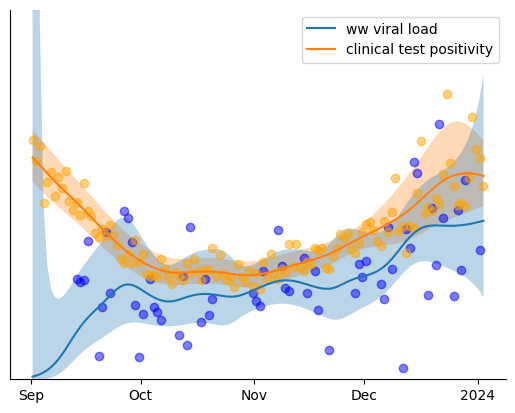

In [273]:
_,ax = plt.subplots()

l,u = lognorm_ci(viral_load, viral_load_varis)
ax.plot(viral_load.index.mid, viral_load / viral_load.std(), label='ww viral load')
ax.fill_between(viral_load.index.mid, l / viral_load.std(), u / viral_load.std(), alpha=0.3)
ax.scatter(viral_load_unsmoothed.index.mid, viral_load_unsmoothed / viral_load.std(), color='blue', alpha=0.5)

l,u = lognorm_ci(s['clinical'], sv['clinical'])
ax.plot(s.index.mid, s['clinical'] / s['clinical'].std(), label='clinical test positivity')
ax.fill_between(s.index.mid, l / s['clinical'].std(), u / s['clinical'].std(), alpha=0.3, zorder=-1)
ax.scatter(su.index.mid, su / s['clinical'].std(), color='orange', alpha=0.5)

ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(locator))
ax.spines[['right', 'top']].set_visible(False)

ax.set_ylim(0, 10)

ax.set_yticks([])

plt.legend()

# ax.set_title('')
plot_out('viral_load_comparison.pdf')

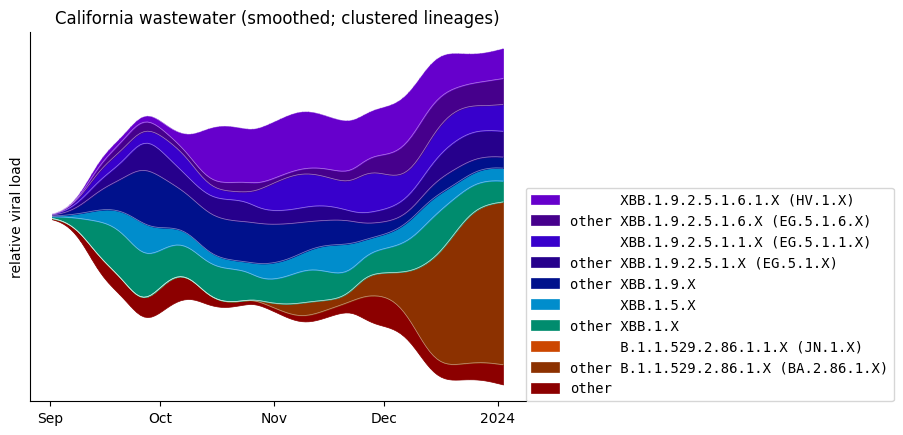

In [278]:
_,ax = plt.subplots()

last_line = outbreak_tools.get_riverplot_baseline(clustered_ww_prevalences_daily, viral_load, k=256)
for lin, color in zip(clustered_ww_prevalences.columns, colors):
    next_line = last_line + clustered_ww_prevalences_daily[lin] * viral_load.interpolate()
    ax.fill_between( clustered_ww_prevalences_daily[lin].index.mid,
                      last_line.interpolate().bfill().ffill(),
                      next_line.interpolate().bfill().ffill(),
                      color=list(color)+[0.25], edgecolor=color, linewidth=0, hatch='|||' )
    ax.plot( clustered_ww_prevalences_daily[lin].index.mid,
              next_line.interpolate(), color='white', linewidth=0.5, alpha=0.5)
    ax.fill_between( clustered_ww_prevalences_daily[lin].index.mid,
                      last_line, next_line, color=list(color), edgecolor=color, linewidth=0.5, label=lin )
    last_line = next_line
plt.legend(loc=(1,0), prop={"family":"monospace"}, reverse=True)


ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(locator))
ax.spines[['right', 'top']].set_visible(False)

# format_dateinterval_axis(plt.gca(), clustered_ww_prevalences.index)
plt.ylabel('relative viral load')
plt.yticks([])
plt.title(f'{state} wastewater (smoothed; clustered lineages)')
plot_out('lin_prev_river_ww.pdf')

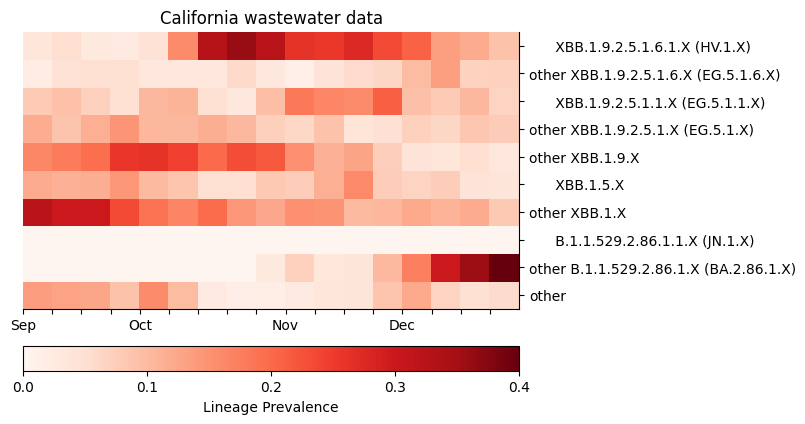

In [279]:
fig, ax = plt.subplots()
plt.pcolor(clustered_ww_prevalences.T, cmap='Reds', vmin=0, vmax=0.4)
plt.xticks(np.arange(0.5, len(clustered_ww_prevalences.index), 1), clustered_ww_prevalences.index)
plt.yticks(np.arange(0.5, len(clustered_ww_prevalences.columns), 1), clustered_ww_prevalences.columns)
format_dateinterval_axis(plt.gca(), clustered_ww_prevalences.index, shift=0.5, tickRight=True)
plt.title(f'{state} wastewater data')
cbar = plt.colorbar(location='bottom',pad = 0.1)
cbar.ax.set_xticks([0,0.1,0.2,0.3,0.4])
cbar.set_label('Lineage Prevalence')

plot_out('lin_prev_matrix_ww.pdf')

#### combined plots

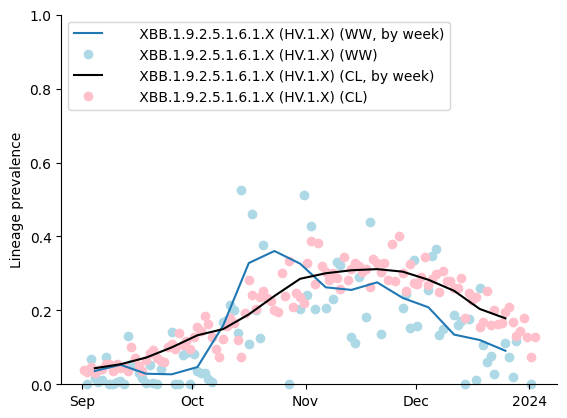

In [280]:
lin = clustered_ww_prevalences.columns[-1]

fig,ax = plt.subplots()
ax.plot(clustered_ww_prevalences.index.mid,clustered_ww_prevalences[[lin]],label = f'{lin} (WW, by week)')
ax.plot(clustered_ww_prevalences_daily_unsmoothed.index.mid,clustered_ww_prevalences_daily_unsmoothed[[lin]],'o', label = f'{lin} (WW)',color = 'lightblue', clip_on=False, zorder=-1)
ax.plot(clustered_cl_prevalences[[lin]].index.mid,clustered_cl_prevalences[[lin]],label = f'{lin} (CL, by week)', color= 'black')
ax.plot(clustered_cl_prevalences_daily_unsmoothed.index.mid,clustered_cl_prevalences_daily_unsmoothed[[lin]],'o', label = f'{lin} (CL)',color = 'pink', clip_on=False, zorder=-1)
ax.set_ylim(0, 1)
ax.set_ylabel('Lineage prevalence')
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(locator))
ax.legend(loc='upper left')
ax.spines[['right', 'top']].set_visible(False)
plot_out('lin_prev_plot.pdf')

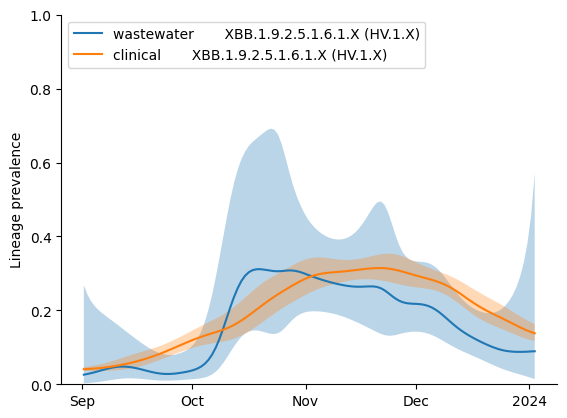

In [281]:
_,ax = plt.subplots()
l,u = lognorm_ci(clustered_ww_prevalences_daily[lin], clustered_ww_prevalences_daily_varis[lin])
ax.plot(clustered_ww_prevalences_daily.index.mid, clustered_ww_prevalences_daily[lin], label=f'wastewater {lin}')
ax.fill_between(clustered_ww_prevalences_daily.index.mid, l, u, alpha=0.3, zorder=-1)

l,u = lognorm_ci(clustered_cl_prevalences_daily[lin], clustered_cl_prevalences_daily_varis[lin])
ax.plot(clustered_cl_prevalences_daily.index.mid, clustered_cl_prevalences_daily[lin], label=f'clinical {lin}')
ax.fill_between(clustered_cl_prevalences_daily.index.mid, l, u, alpha=0.3, zorder=-1)

ax.set_ylim(0, 1)
ax.set_ylabel('Lineage prevalence')
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(locator))
ax.legend(loc='upper left')
ax.spines[['right', 'top']].set_visible(False)
plot_out('lin_prev_plot_rolling.pdf')

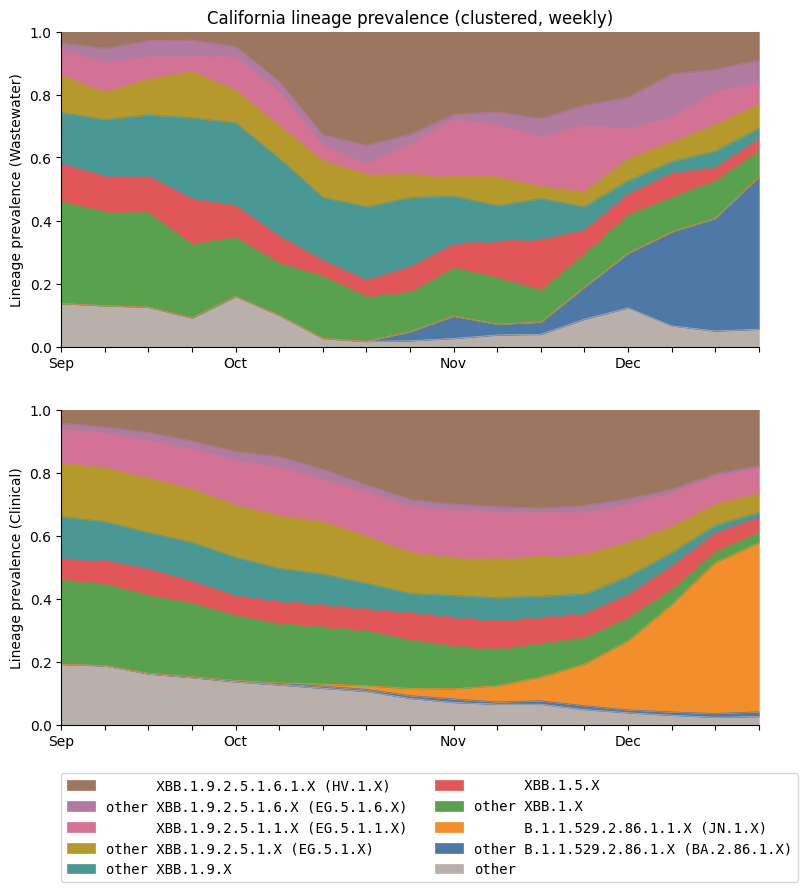

In [282]:
fig, axs = plt.subplots(2,1, sharex=True, figsize=(9,9))

cm = ["#bab0ab", "#4E79A7", "#f28e2b", "#59a14f","#e15759", "#499894","#B6992D",  "#D37295", "#B07AA1","#9D7660", "#bcbd22", "#aecBe8", "#FFBE7D",  "#8CD17D", "#FF9D9A",  "#86BCB6", "#F1CE63","#FABFD2",  "#D4A6C8", "#D7B5A6",  "#79706E"]

clustered_ww_prevalences.plot(kind='area', stacked=True, color=cm[:len(clustered_ww_prevalences)], linewidth=0.5, ax=axs[0])
axs[0].set_ylim(0, 1)
axs[0].set_ylabel('Lineage prevalence (Wastewater)')
axs[0].spines[['right', 'top']].set_visible(False)

clustered_cl_prevalences.plot(kind='area', stacked=True, color=cm[:len(clustered_cl_prevalences)], linewidth=0.5, ax=axs[1])
axs[1].set_ylim(0, 1)
axs[1].set_ylabel('Lineage prevalence (Clinical)')
axs[1].spines[['right', 'top']].set_visible(False)

format_dateinterval_axis(axs[1], clustered_ww_prevalences.index, narrow=0.5)
axs[1].legend(loc=(0,-0.5), prop={"family":"monospace"}, reverse=True, ncols=2)
axs[0].legend().remove()
axs[0].set_title(f'{state} lineage prevalence (clustered, weekly)')

axs[0].tick_params(axis='both', which='both',labelbottom=True)
axs[1].tick_params(axis='both', which='both')
plt.subplots_adjust(hspace=0.2)

plot_out('lin_prev_stacked_stacked.pdf')

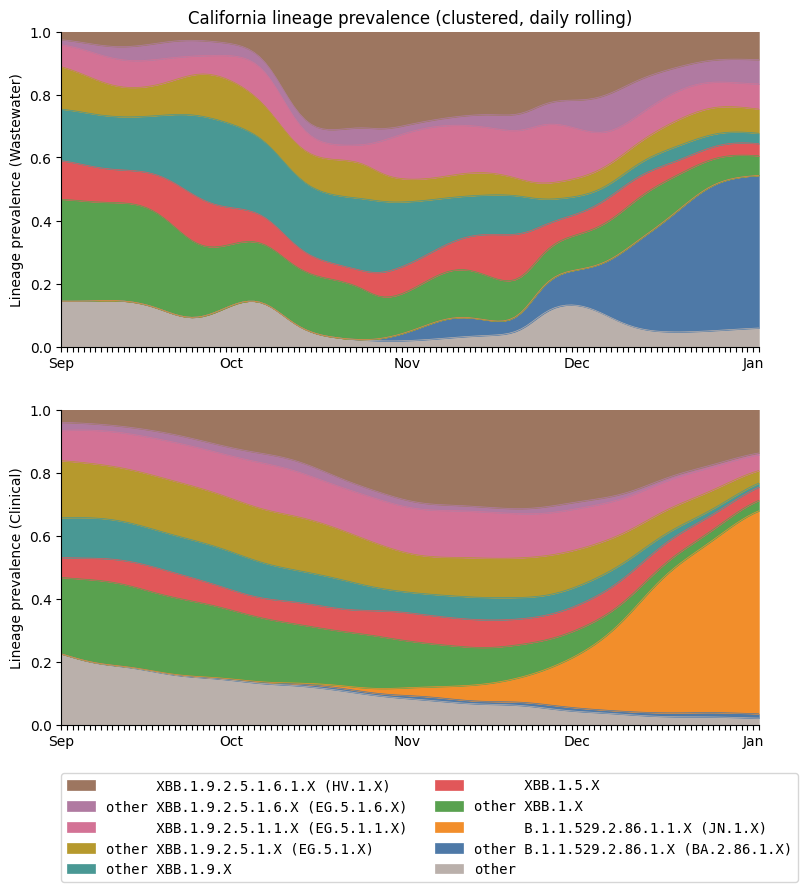

In [283]:
fig, axs = plt.subplots(2,1, sharex=True, figsize=(9,9))

clustered_ww_prevalences_daily.plot(kind='area', stacked=True, color=cm[:len(clustered_ww_prevalences_daily)], linewidth=0.5, ax=axs[0])
axs[0].set_ylim(0, 1)
axs[0].set_ylabel('Lineage prevalence (Wastewater)')
axs[0].spines[['right', 'top']].set_visible(False)

clustered_cl_prevalences_daily.plot(kind='area', stacked=True, color=cm[:len(clustered_cl_prevalences_daily)], linewidth=0.5, ax=axs[1])
axs[1].set_ylim(0, 1)
axs[1].set_ylabel('Lineage prevalence (Clinical)')
axs[1].spines[['right', 'top']].set_visible(False)

format_dateinterval_axis(axs[1], clustered_ww_prevalences_daily.index, narrow=0.5)
axs[1].legend(loc=(0,-0.5), prop={"family":"monospace"}, reverse=True, ncols=2)
axs[0].legend().remove()
axs[0].set_title(f'{state} lineage prevalence (clustered, daily rolling)')

axs[0].tick_params(axis='both', which='both',labelbottom=True)
axs[1].tick_params(axis='both', which='both')
plt.subplots_adjust(hspace=0.2)

plot_out('lin_prev_stacked_stacked.pdf')

In [284]:
groups = outbreak_clustering.gather_groups(clusters, combined_prevalences)
clustered_prevalences = pd.concat([clustered_ww_prevalences, clustered_cl_prevalences], keys=['A_wastewater', 'B_clinical'])
gcolors = [[colors[root_lineages.index(n['name'])] for n in g] for g in groups]
groups = [ clustered_prevalences[
        [clustered_prevalences.columns[root_lineages.index(node['name'])] for node in group]
    ].swaplevel(axis='rows').sort_index() for group in groups]

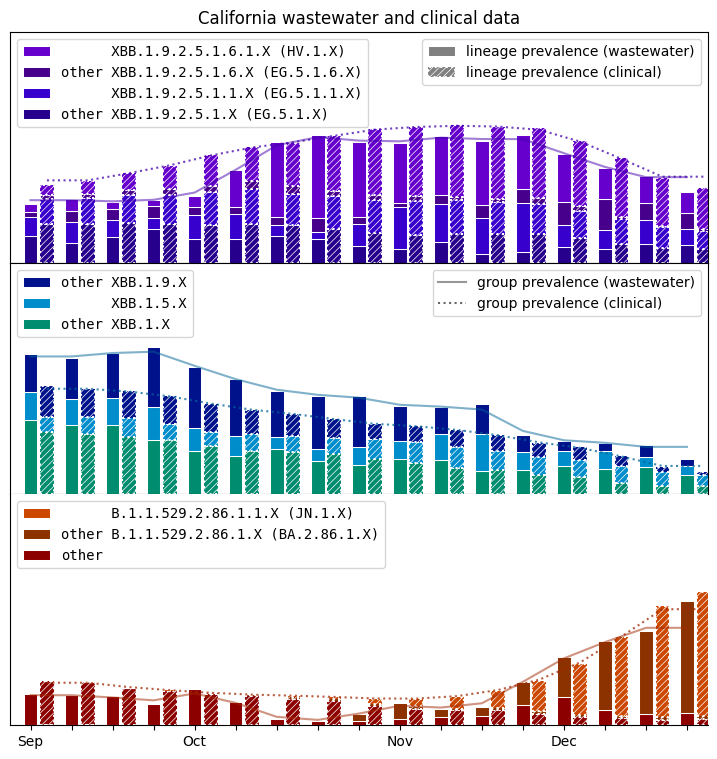

In [285]:
fig, axs = plt.subplots(len(groups),1, sharex=True, figsize=(9,9))
barstyle = { 'linewidth': 0.75, 'edgecolor':'white' }
cbarstyle = { 'linewidth': 1.5, 'linestyle':':', 'hatch': '/////' }
linestyle = { 'alpha': 0.5 }
clinestyle = { 'alpha': 0.75, 'linestyle': ':' }

def trendline(lingroup):
    line = lingroup.sum(axis=1)
    line[lingroup.isna().all(axis=1)] = pd.NA
    line = line.interpolate().rolling(3, closed=None, center=True).mean()/2 + line.interpolate()/2
    return line.bfill().ffill()

for i, (ax, g, c) in enumerate(zip(axs, groups, gcolors)):
    ww = g.xs('A_wastewater', level=1)
    cl = g.xs('B_clinical', level=1)
    ww.plot(kind='bar', stacked=True, width=0.3333, color=c, ax=ax, **barstyle)
    ax.add_artist(ax.legend(loc='upper left', prop={"family":"monospace"}, reverse=True)) # save lin legend
    cl.plot(kind='bar', stacked=True, width=0.3333, color=c, ax=ax, **(barstyle|cbarstyle))
    for cbar in ax.patches[-cl.size:]: cbar.set_x(cbar.get_x() + 0.4) # x-offset clinical bars
    trendline(ww).plot(color=np.mean(c, axis=0), ax=ax, **linestyle)
    trendline(cl).plot(color=np.mean(c, axis=0), ax=ax, **(linestyle|clinestyle))
    ax.lines[-1].set_xdata(ax.lines[-1].get_xdata() + 0.4) # x-offset clinical trend to match bars
    ax.legend().remove() # skip auto legend
    ax.set_yticks([])
    ax.set_ylim(0,1)

axs[0].set_title(f'{state} wastewater and clinical data')
axs[0].legend([ # custom legend for ww v cl bars
        matplotlib.patches.Patch(facecolor='gray', **barstyle),
        matplotlib.patches.Patch(facecolor='gray', **(barstyle|cbarstyle))],
    ['lineage prevalence (wastewater)', 'lineage prevalence (clinical)'], loc='upper right')
axs[1].legend([ # custom legend for ww v clinical lines
        matplotlib.lines.Line2D([], [], color='#333', **linestyle),
        matplotlib.lines.Line2D([], [], color='#333', **(linestyle|clinestyle))],
    ['group prevalence (wastewater)', 'group prevalence (clinical)'], loc='upper right')
axs[-1].set_xlim(axs[-1].get_xlim()[0], axs[-1].get_xlim()[1] + 0.4)
format_dateinterval_axis(axs[-1], ww.index)
plt.subplots_adjust(wspace=0, hspace=0)
plot_out('lin_prev_stacked_grouped.pdf')